In [3]:
import numpy as np
import matplotlib.pyplot as plt
path = 'path-to-dataset'

In [4]:
# compute the value of the logistic function for single neuron dynamics
# given the slope, m, and the shift, s
def compute_s(x, m ,s):
    y = np.zeros((len(x), 1))
    for idx in range(len(x)):
        y[idx, 0] = 1/(1 + np.exp(-m*(x[idx, 0] - s)))
    return y

In [5]:
# compute distance
def compute_d(N, s):
    y = np.zeros((N, N))
    for idx in range(N):
        for jdx in range(N):
            y[idx, jdx] = np.exp(-0.5*(np.min([np.abs(idx-jdx), N - np.abs(idx-jdx)])/s) ** 2)
    return y

In [6]:
# create the sharp learning network composed of N_POP populations of
# N_NEURONS neurons and init each struct weight and activity matrices
def create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT):
    wta_profile = GAMMA * compute_d(N_NEURONS, SIGMA) - DELTA;
    wext = np.random.rand(N_NEURONS, N_NEURONS)*MAX_INIT_RANGE;
    populations = {}
    for pop_idx in range(N_POP):
        populations[pop_idx] = {'idx': pop_idx,
                                'lsize': N_NEURONS,
                                'Wint': wta_profile,
                                'Wext': wext / np.sum(wext),
                                'a': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT,
                                'h': np.zeros((N_NEURONS, 1))*TARGET_VAL_ACT
                               }
    return populations

In [7]:
# function to generate the population encoded variable as input for the net
# here we also need to encode variables which are in both +/- ranges
# we need to take into accound the encoding for the tuning curves
# distribution
def population_encoder(x, range_input, N):
    sig = .1  # Standard deviation
    K = 1; # max firing rate (Hz) (ignore - not modeling nurophysiology here :)
    # pattern of activity, or output tuning curve between [-range, range]
    R = np.zeros((N, 1))
    # calculate output 
    for j in range(N):  # for each neuron in the population
        R[j, 0] = K*np.exp( -(x - (-range_input+(j)*(range_input/((N)/2))))**2 / (2*sig**2))
    return R

In [8]:
# Read csv / dataset
def read_sensor(path):
    return np.genfromtxt(path, delimiter = ',')

In [9]:
# print learnt relation
def print_heatmap(arr):
    plt.figure()
    plt.imshow(arr)
    plt.show()

In [19]:
## INIT SIMULATION
# enables dynamic visualization on network runtime
DYN_VISUAL      = 1
# number of populations in the network
N_POP           = 2
# number of neurons in each population
N_NEURONS       = 200
# max range value @ init for weights and activities in the population
MAX_INIT_RANGE  = 1
# WTA circuit settling threshold
EPSILON         = 1e-3
sensory_data = read_sensor(path)

DATASET_LEN     = len(sensory_data[:, 0])
## INIT NETWORK DYNAMICS
# epoch iterator in outer loop (HL, HAR)
t       = 1;
# network iterator in inner loop (WTA)
tau     = 1;
# constants for WTA circuit (convolution based WTA), these will provide a
# profile peaked at ~ TARGET_VAL_ACT
DELTA   = -0.005                   # displacement of the convolutional kernel (neighborhood)
SIGMA   = 5.0                      # standard deviation in the exponential update rule
SL      = 4.5                      # scaling factor of neighborhood kernel
GAMMA   = SL/(SIGMA*np.sqrt(2*np.pi))    # convolution scaling factor
# constants for Hebbian linkage
ALPHA_L = 1.0*1e-2                 # Hebbian learning rate
ALPHA_D = 1.0*1e-2                 # Hebbian decay factor ALPHA_D >> ALPHA_L
# constants for HAR
C       = 0.005                    # scaling factor in homeostatic activity regulation
TARGET_VAL_ACT  = 0.4              # amplitude target for HAR
A_TARGET        = TARGET_VAL_ACT*np.ones((N_NEURONS, 1)) # HAR target activity vector
# constants for neural units in neural populations
M       = 1; # slope in logistic function @ neuron level
S       = 10.0; # shift in logistic function @ neuron level
# activity change weight (history vs. incoming knowledge)
ETA     = 0.25;
## CREATE NETWORK AND INITIALIZE
# create a network given the simulation constants
populations = create_init_network(N_POP, N_NEURONS, GAMMA, SIGMA, DELTA, MAX_INIT_RANGE, TARGET_VAL_ACT)
# buffers for changes in activity in WTA loop
act = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
old_act = np.zeros((N_NEURONS, N_POP))*MAX_INIT_RANGE
# buffers for running average of population activities in HAR loop
old_avg = np.zeros((N_POP, N_NEURONS))
cur_avg = np.zeros((N_POP, N_NEURONS))
# the new rate values
delta_a1 = np.zeros((N_NEURONS, 1))
## NETWORK SIMULATION LOOP
# # present each entry in the dataset for MAX_EPOCHS epochs to train the net

for didx in range(DATASET_LEN):
    # pick a new sample from the dataset and feed it to the input (noiseless input)
    # population in the network (in this case X -> A -> | <- B <- Y)
    X = population_encoder(sensory_data[didx, 0], np.max(sensory_data[:, 0]),  N_NEURONS)
    Y = population_encoder(sensory_data[didx, 1], np.max(sensory_data[:, 1]),  N_NEURONS)
    # normalize input such that the activity in all units sums to 1.0
    X /= np.sum(X);
    Y /= np.sum(Y);
    # clamp input to neural populations
    populations[0]['a'] = X;
    populations[1]['a'] = Y;
    # given the input sample wait for WTA circuit to settle and then
    # perform a learning step of Hebbian learning and HAR
    while True:
        # compute changes in activity
        delta_a0 = compute_s(populations[0]['h'] + np.matmul(populations[0]['Wext'], populations[1]['a']) + 
                             np.matmul(populations[0]['Wint'],populations[0]['a']), 
                             M, 
                             S)
        delta_a1 = compute_s(populations[1]['h'] + np.matmul(populations[1]['Wext'], populations[0]['a']) + 
                             np.matmul(populations[1]['Wint'], populations[1]['a']), 
                             M, 
                             S)
        # update the activities of each population
        populations[0]['a'] = (1-ETA)*populations[0]['a'] + ETA*delta_a0
        populations[1]['a'] = (1-ETA)*populations[1]['a'] + ETA*delta_a1
        # current activation values holder
        for pop_idx in range(N_POP):
            act[:, pop_idx] = populations[pop_idx]['a'].reshape(-1)
        # check if activity has settled in the WTA loop
        q = (np.sum(np.sum(np.abs(act - old_act)))/(N_POP*N_NEURONS))
        if q <= EPSILON:
            tau = 1
            break
        # update history of activities
        old_act = act
        # increment time step in WTA loop
        tau += 1
    # update Hebbian linkage between the populations (decaying Hebbian rule)
    populations[0]['Wext'] = (1-ALPHA_D)*populations[0]['Wext'] + ALPHA_L*np.matmul(populations[0]['a'],populations[1]['a'].transpose())
    populations[1]['Wext'] = (1-ALPHA_D)*populations[1]['Wext'] + ALPHA_L*np.matmul(populations[1]['a'],populations[0]['a'].transpose())
    # compute the inverse time for exponential averaging of HAR activity
    omegat = 0.002 + 0.998/(t+2)
    # for each population in the network
    for pop_idx in range(N_POP):
        # update Homeostatic Activity Regulation terms
        # compute exponential average of each population at current step
        cur_avg[pop_idx, :] = (1-omegat)*old_avg[pop_idx, :] + omegat*populations[pop_idx]['a'].transpose()
        # update homeostatic activity terms given current and target act.
        populations[pop_idx]['h'] = populations[pop_idx]['h'] + C*(TARGET_VAL_ACT - cur_avg[pop_idx, :].transpose())
    # update averging history
    old_avg = cur_avg
    # increment timestep for HL and HAR loop
    t = t + 1

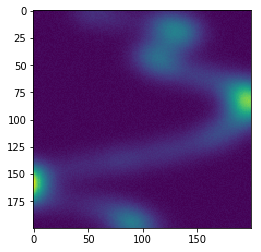

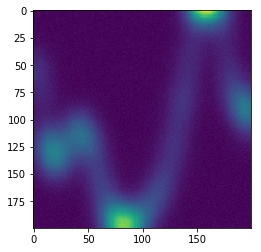

In [20]:
print_heatmap(populations[0]['Wext'])
print_heatmap(populations[1]['Wext'])